In [2]:
import torch

# Path to your .pt file
data_path = r"C:\Users\andre\Documents\School\Hoger\Masterproef\Results\PCA analysis of embedding vectors\studied_nodes\a3.h11\third_time_charm_extracted_activations_depth1_batch0_head_a3h11.pt"

# Load the data
# loaded_data = torch.load(data_path)

# If you need to load to a specific device
loaded_data = torch.load(data_path, map_location=torch.device('cpu'))  # or 'cuda'

# Print information about the loaded data
print(f"Data loaded successfully from {data_path}")
print(f"Type of loaded data: {type(loaded_data)}")

# If it's a dictionary or has attributes you can explore them
if isinstance(loaded_data, dict):
    print(f"Keys in the data: {loaded_data.keys()}")

C:\Users\andre\AppData\Local\Temp\ipykernel_29960\3774668443.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(data_path, map_location=torch.devi

Data loaded successfully from C:\Users\andre\Documents\School\Hoger\Masterproef\Results\PCA analysis of embedding vectors\studied_nodes\a3.h11\third_time_charm_extracted_activations_depth1_batch0_head_a3h11.pt
Type of loaded data: <class 'dict'>
Keys in the data: dict_keys(['pre_attention_layer_residual', 'post_attention_layer_residual', 'attention_layer_output', 'attention_layer_result', 'attention_layer_z_score'])


In [3]:
print(loaded_data)

{'pre_attention_layer_residual': tensor([[[ 0.1527, -0.3716, -0.1838,  ...,  0.2817,  0.2459, -0.5079],
         [-0.7966, -0.2898,  0.1316,  ..., -0.2937,  0.4902,  0.1538],
         [-1.3036, -0.0035, -0.3103,  ...,  0.8823,  0.5158, -0.0878],
         ...,
         [-0.1009, -0.3634,  0.0704,  ...,  0.8787, -0.3605, -0.7523],
         [ 0.0099, -0.1519,  0.2424,  ...,  0.6307, -0.2627, -0.9477],
         [-0.1228, -0.0914,  0.1272,  ...,  0.4483, -0.5679, -1.0052]],

        [[ 0.3588, -0.4493, -0.0115,  ...,  0.2870,  0.2775, -0.5885],
         [-0.7652,  0.8459, -0.5784,  ...,  0.8093,  0.2186, -0.6163],
         [-0.2473, -0.2909, -0.6381,  ...,  0.4574,  0.2713,  0.9507],
         ...,
         [ 0.3751, -0.3293,  0.3666,  ...,  0.9590, -0.2366, -0.8305],
         [ 0.3592, -0.3844,  0.4170,  ...,  0.7919,  0.0165, -1.0393],
         [ 0.6640, -0.7506,  0.2960,  ...,  0.4051,  0.3639, -1.3735]],

        [[ 0.0907, -0.2147, -0.1197,  ...,  0.1943,  0.1289, -0.4487],
         [ 0

In [4]:
print(loaded_data["attention_layer_output"].shape)
print(loaded_data["pre_attention_layer_residual"].shape)
print(loaded_data["post_attention_layer_residual"].shape)
print(loaded_data["attention_layer_result"].shape)
print(loaded_data["attention_layer_z_score"].shape)

torch.Size([64, 142, 768])
torch.Size([64, 142, 768])
torch.Size([64, 142, 768])
torch.Size([64, 142, 768])
torch.Size([64, 142, 64])


In [5]:
# Create a function to map property tokens to their associated entities
def create_entity_property_mapping(facts_df):
    """Create a mapping from property token indices to their associated entity names"""
    entity_property_map = {doc_id: {} for doc_id in facts_df['doc_id'].unique()}
    
    # Group by doc_id and sentence_idx to process each fact sentence
    for (doc_id, sent_idx), group in facts_df.groupby(['doc_id', 'sent_idx']):
        # Sort by position within sentence
        sentence_tokens = group.sort_values('token_idx')
        
        # Find OBJECT and PROPERTY tokens in this sentence
        objects = sentence_tokens[sentence_tokens['semantic_label'] == 'OBJECT']
        properties = sentence_tokens[sentence_tokens['semantic_label'] == 'PROPERTY']
        # print(objects)
        # print(properties)
        
        # If we have both an object and property in this sentence
        if len(objects) > 0 and len(properties) > 0:
            # Use the first object as the associated entity
            entity = objects.iloc[0]['token']
            # print(f"Entity: {entity}")
            
            for _, prop_row in properties.iterrows():
                # Map this property's total_idx to the entity name
                entity_property_map[doc_id][prop_row['total_idx']] = entity
    
    return entity_property_map

# Modify the extract_embeddings function to use entity names for properties
def extract_embeddings(filtered_tokens, activations, hook_point, doc_to_batch, entity_map=None, use_entity_labels=False):
    """Extract embeddings for the specified tokens at a specific hook point"""
    embeddings = []
    labels = []
    
    for _, row in filtered_tokens.iterrows():
        doc_id = row['doc_id']
        batch_idx = doc_to_batch[doc_id]
        if batch_idx >= activations[hook_point].shape[0]:
            return np.array(embeddings), labels
        
        total_idx = int(row['total_idx'])
        
        # if use_entity_labels and entity_map is not None:
            # Ensure the entity map has the doc_id
            # print(batch_idx, doc_id)
        # Use entity name for property tokens if requested and available
        if use_entity_labels and entity_map[doc_id] and total_idx in entity_map[doc_id]:
            token_label = entity_map[doc_id][total_idx]
        else:
            token_label = row['token']
        
        # Check if this token index exists in the activations
        if total_idx < activations[hook_point].shape[1]:
            embedding = activations[hook_point][batch_idx, total_idx, :].numpy()
            embeddings.append(embedding)
            labels.append(token_label)
        else:
            Exception(f"Total index {total_idx} out of bounds for hook point {hook_point} in batch {batch_idx}")        

In [6]:
# Create a function to plot PCA on a specific axis
def plot_pca_on_axis(embeddings, labels, title, ax):
    """Perform PCA and create a scatter plot on the given axis"""
    # Apply PCA
    pca = PCA(n_components=2)
    projected = pca.fit_transform(embeddings)
    
    # Create a colormap for the unique labels
    unique_labels = sorted(list(set(labels)))
    num_labels = len(unique_labels)
    
    # Choose an appropriate colormap based on the number of unique labels
    if num_labels <= 10:
        cmap = plt.cm.tab10
    elif num_labels <= 20:
        cmap = plt.cm.tab20
    else:
        # For more than 20 unique labels, we'll create a custom colormap
        colors = plt.cm.rainbow(np.linspace(0, 1, num_labels))
        cmap = ListedColormap(colors)
    
    # Create a dictionary mapping labels to colors
    label_to_color = {label: cmap(i % cmap.N) for i, label in enumerate(unique_labels)}
    
    # Plot each label group separately to ensure correct legend
    for label in unique_labels:
        mask = np.array(labels) == label
        ax.scatter(
            projected[mask, 0], 
            projected[mask, 1],
            c=[label_to_color[label]],
            label=label,
            alpha=0.7, 
            s=80
        )
    
    # Add a legend with proper handling of many items
    if num_labels > 10:
        # If we have many labels, place legend outside plot
        ax.legend(
            title="Token Values",
            loc='center left',
            bbox_to_anchor=(1, 0.5),
            ncol=1
        )
    else:
        # For fewer labels, keep legend inside
        ax.legend(title="Token Values", loc='best')
    
    # Set labels and title
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    ax.set_title(title, fontsize=11)
    ax.grid(alpha=0.3)

In [7]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from collections import defaultdict
from matplotlib.colors import ListedColormap

# Load the activations data
activation_path = r"C:\Users\andre\Documents\School\Hoger\Masterproef\Results\PCA analysis of embedding vectors\studied_nodes\a3.h11\final_extracted_activations_depth1_batch0_head_a3h11.pt"
token_data_path = r"c:\Users\andre\Documents\School\Hoger\Masterproef\Data\rule-reasoning-dataset-V2020.2.5\rule-reasoning-dataset-V2020.2.5.0\original\depth-1\filtered_AttNoneg\formatted_RD-1_PS-proof\labeled_tokens.tsv"

# Load data - fix the warning by adding weights_only=True
activations = torch.load(activation_path, map_location=torch.device('cpu'), weights_only=True)
token_data = pd.read_csv(token_data_path, sep='\t')

# Define hook points
hook_points = ["attention_layer_output", "pre_attention_layer_residual", "post_attention_layer_residual", "attention_layer_result", "attention_layer_z_score", "attention_layer_value_vectors"]

# Check dimensions
print("Activation dimensions:")
for hook in hook_points:
    print(f"{hook}: {activations[hook].shape}")

Activation dimensions:
attention_layer_output: torch.Size([64, 142, 768])
pre_attention_layer_residual: torch.Size([64, 142, 768])
post_attention_layer_residual: torch.Size([64, 142, 768])
attention_layer_result: torch.Size([64, 142, 768])
attention_layer_z_score: torch.Size([64, 142, 64])
attention_layer_value_vectors: torch.Size([64, 142, 64])


In [8]:
# Filter for OBJECT and PROPERTY tokens from facts
facts = token_data[token_data['fact_rule'] == 'fact']
object_tokens = facts[facts['semantic_label'] == 'OBJECT'].copy()
property_tokens = facts[facts['semantic_label'] == 'PROPERTY'].copy()

print(f"Found {len(object_tokens)} OBJECT tokens and {len(property_tokens)} PROPERTY tokens in facts")

# Create a mapping from doc_id to batch index
unique_docs = token_data['doc_id'].unique()
doc_to_batch = {doc_id: i for i, doc_id in enumerate(unique_docs)}

Found 5869 OBJECT tokens and 5869 PROPERTY tokens in facts


In [9]:
# Create the mapping of property total_idx to the entity value it says something about before plotting
entity_property_map = create_entity_property_mapping(facts)

In [129]:
def visualize_pca_for_tokens(activations, object_tokens, property_tokens, hook_points, doc_to_batch, entity_property_map, use_entity_labels=False):
    """
    Visualize PCA projections of token embeddings for multiple hook points.
    
    Parameters:
    -----------
    activations : dict
        Dictionary containing activation tensors for different hook points
    object_tokens : DataFrame
        DataFrame containing the OBJECT tokens
    property_tokens : DataFrame
        DataFrame containing the PROPERTY tokens
    hook_points : list
        List of hook point names to analyze
    doc_to_batch : dict
        Mapping from document IDs to batch indices
    entity_property_map : dict
        Mapping from property token indices to their associated entities
    """
    # Create the figure
    fig, axes = plt.subplots(len(hook_points), 2, figsize=(18, 5*len(hook_points)))

    # Process each hook point
    for i, hook_point in enumerate(hook_points):
        print(f"\nProcessing {hook_point}...")
        
        # Process OBJECT tokens (left column)
        object_embeddings, object_labels = extract_embeddings(
            object_tokens, activations, hook_point, doc_to_batch, entity_map=entity_property_map, use_entity_labels=False
        )
        print(f"  Found {len(object_embeddings)} ENTITY embeddings")
        
        if len(object_embeddings) > 0:
            # Plot in the left column
            ax = axes[i, 0] if len(hook_points) > 1 else axes[0]
            plot_pca_on_axis(
                object_embeddings, 
                object_labels,
                f"PCA of {hook_point}\nENTITY tokens labeled by entity value",
                ax
            )
        else:
            ax = axes[i, 0] if len(hook_points) > 1 else axes[0]
            ax.text(0.5, 0.5, "No ENTITY embeddings found", ha='center', va='center')
            ax.set_title(f"PCA of {hook_point}\nENTITY tokens labeled by entity value")
        
        # Process PROPERTY tokens (right column)
        property_embeddings, property_labels = extract_embeddings(
            property_tokens, activations, hook_point, doc_to_batch, entity_map=entity_property_map, use_entity_labels=use_entity_labels
        )
        print(f"  Found {len(property_embeddings)} PROPERTY embeddings")
        
        if len(property_embeddings) > 0:
            # Plot in the right column
            ax = axes[i, 1] if len(hook_points) > 1 else axes[1]
            plot_pca_on_axis(
                property_embeddings, 
                property_labels,
                f"PCA of {hook_point}\nPROPERTY tokens labeled by {'entity value'if use_entity_labels else 'property value'}",
                ax
            )
        else:
            ax = axes[i, 1] if len(hook_points) > 1 else axes[1]
            ax.text(0.5, 0.5, "No PROPERTY embeddings found", ha='center', va='center')
            ax.set_title(f"PCA of {hook_point}\nPROPERTY tokens")

    plt.tight_layout()
    return fig

# Example usage:
# fig = visualize_pca_for_tokens(activations, object_tokens, property_tokens, hook_points, doc_to_batch, entity_property_map)
# fig.savefig("combined_pca_plots_entity_labeled.png", bbox_inches='tight', dpi=300)
# plt.show()


Processing attention_layer_output...
  Found 477 OBJECT embeddings
  Found 477 PROPERTY embeddings

Processing pre_attention_layer_residual...
  Found 477 OBJECT embeddings
  Found 477 PROPERTY embeddings

Processing post_attention_layer_residual...
  Found 477 OBJECT embeddings
  Found 477 PROPERTY embeddings

Processing attention_layer_result...
  Found 477 OBJECT embeddings
  Found 477 PROPERTY embeddings

Processing attention_layer_z_score...
  Found 477 OBJECT embeddings
  Found 477 PROPERTY embeddings

Processing attention_layer_value_vectors...
  Found 477 OBJECT embeddings
  Found 477 PROPERTY embeddings


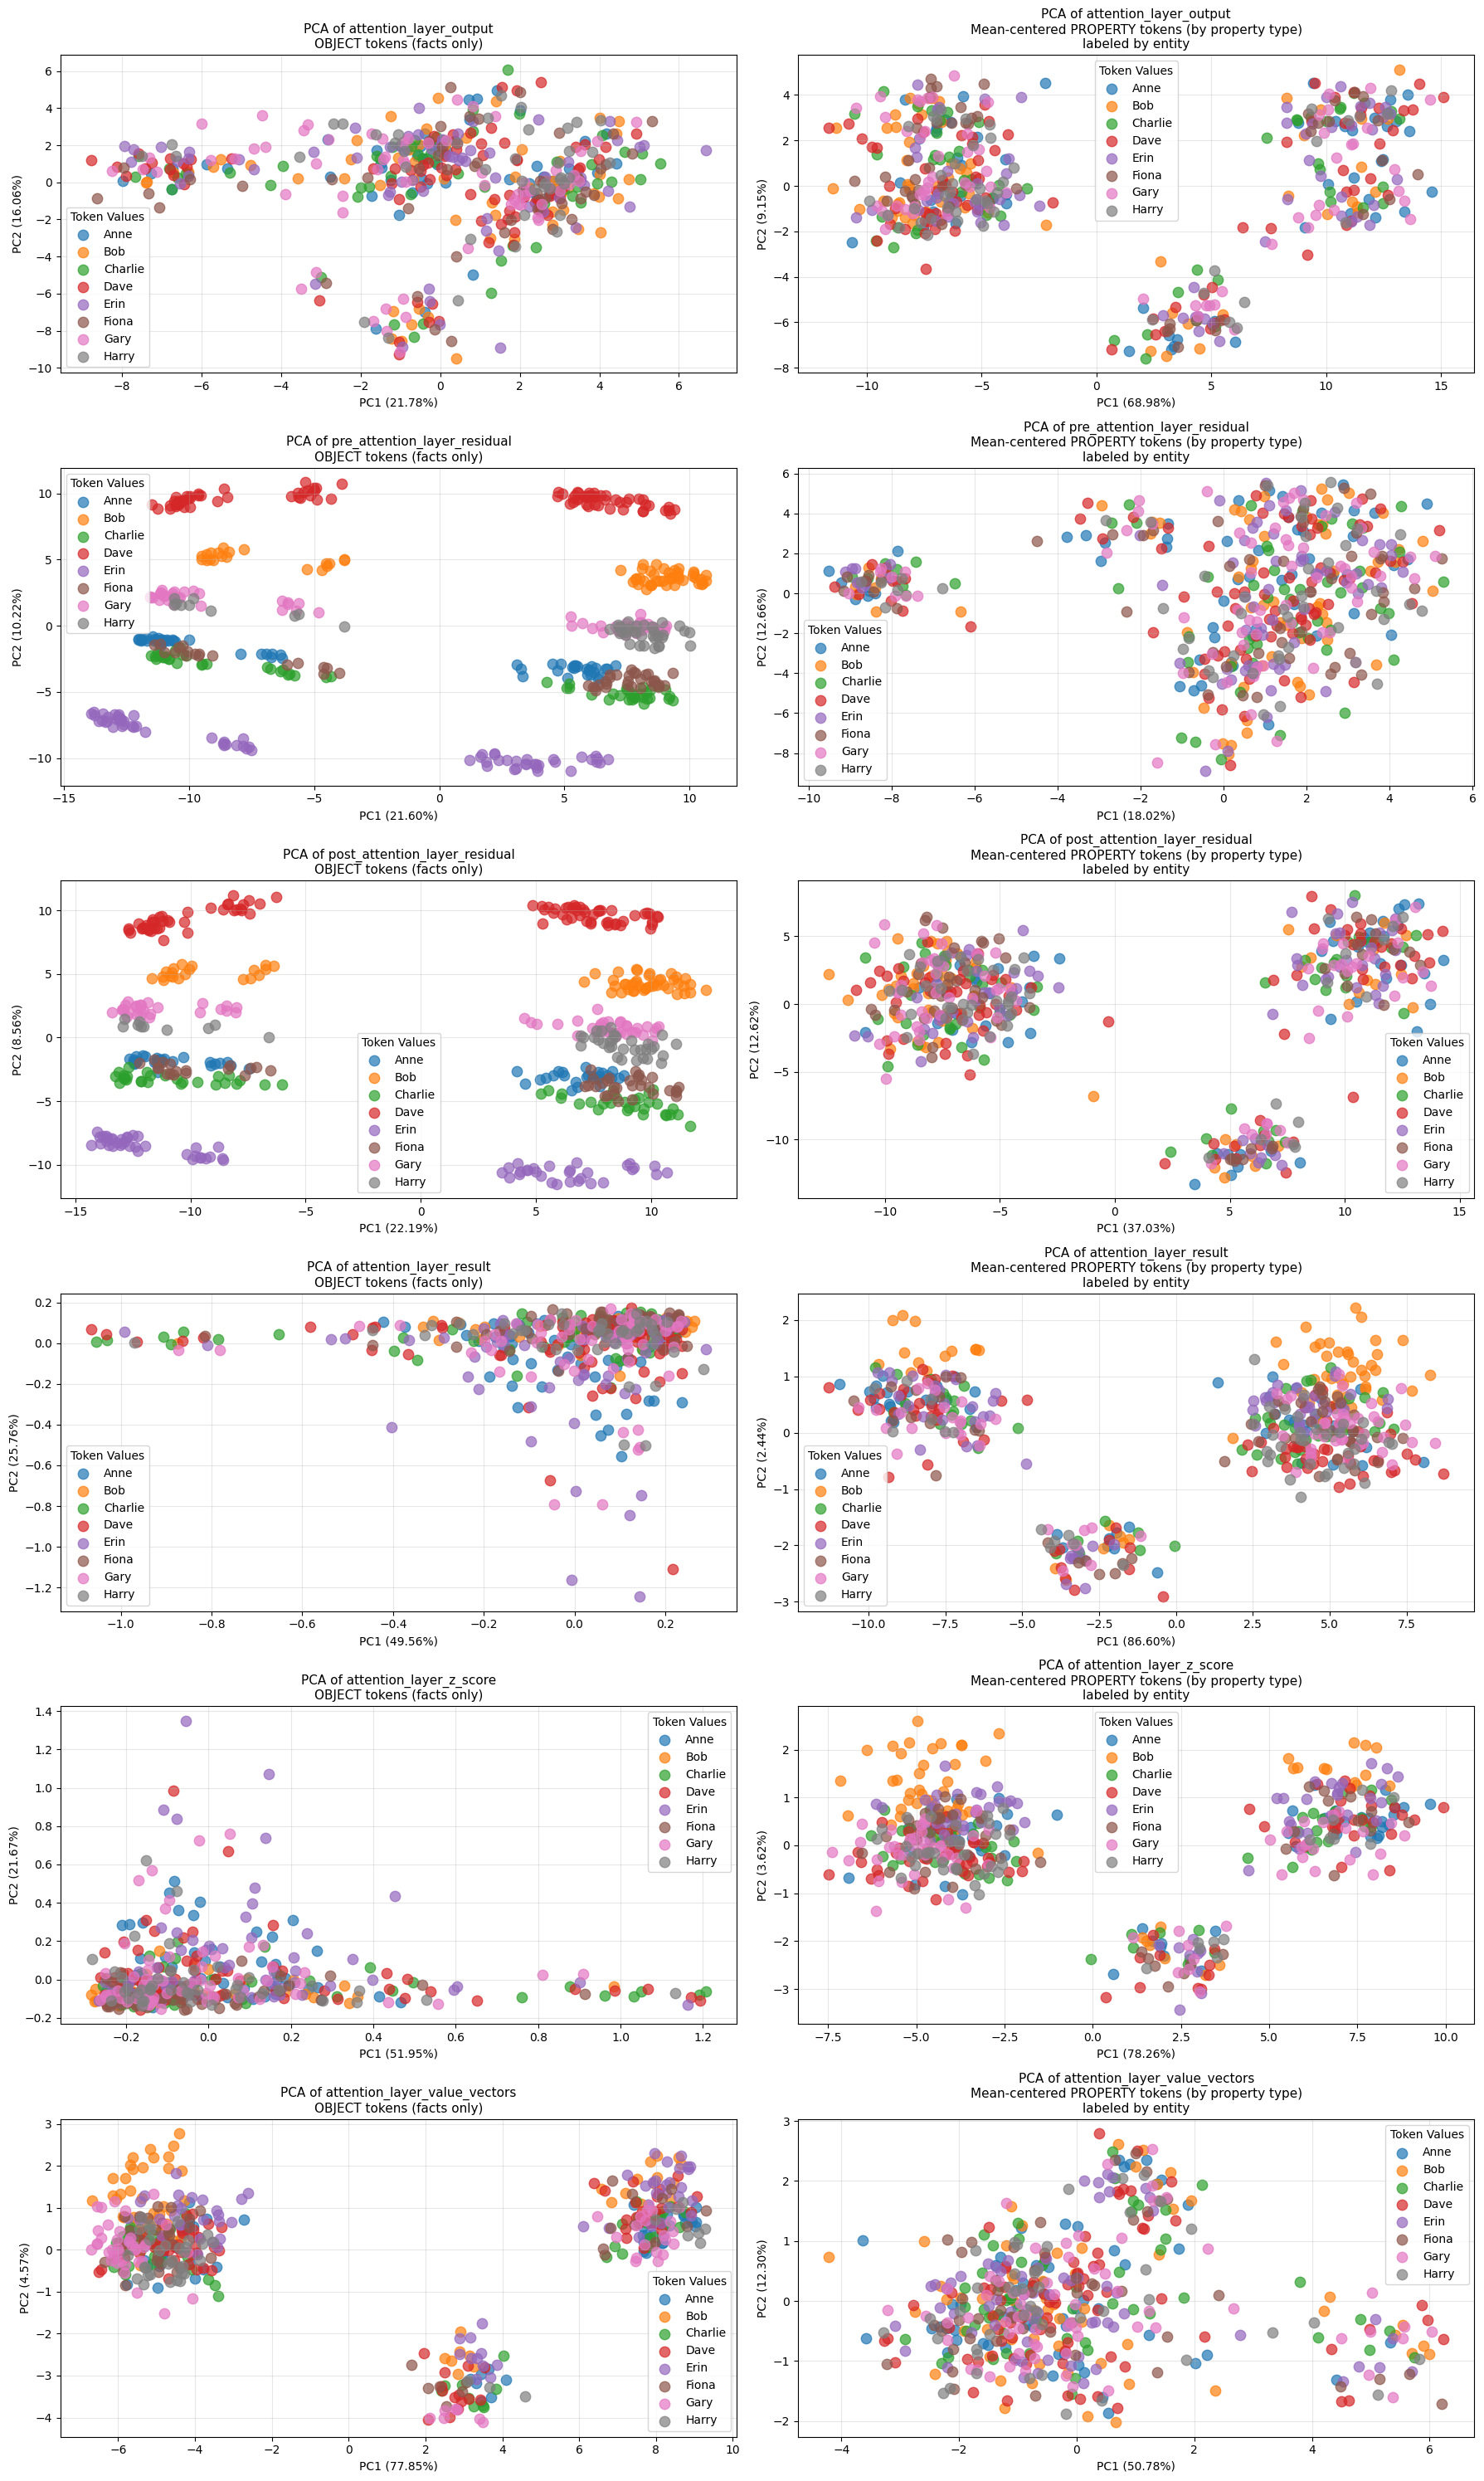

In [ ]:
# Add this function to your code to perform token-type mean-centering
def mean_center_by_token_type(embeddings, labels):
    """
    Perform token-type mean-centering on embeddings
    
    For each unique token type (e.g., 'cold', 'quiet'), this function:
    1. Computes the mean embedding vector
    2. Subtracts this mean from all embeddings of that type
    
    Returns the mean-centered embeddings
    """
    embeddings = np.array(embeddings)
    unique_tokens = set(labels)
    centered_embeddings = np.zeros_like(embeddings)
    
    # Process each token type separately
    for token in unique_tokens:
        # Find indices for this token type
        token_indices = [i for i, label in enumerate(labels) if label == token]
        
        # Skip if we don't have enough samples
        if len(token_indices) < 2:
            centered_embeddings[token_indices] = embeddings[token_indices]
            continue
            
        # Calculate mean embedding for this token type
        token_embeddings = embeddings[token_indices]
        token_mean = np.mean(token_embeddings, axis=0)
        
        # Subtract mean from each embedding of this type
        centered_embeddings[token_indices] = token_embeddings - token_mean
        
    return centered_embeddings

# # Now modify your plotting loop to include this step for PROPERTY tokens
# fig, axes = plt.subplots(len(hook_points), 2, figsize=(18, 5*len(hook_points)))

# # Process each hook point
# for i, hook_point in enumerate(hook_points):
#     print(f"\nProcessing {hook_point}...")
    
#     # Process OBJECT tokens (left column)
#     object_embeddings, object_labels = extract_embeddings(
#         object_tokens, activations, hook_point, doc_to_batch, entity_map=entity_property_map, use_entity_labels=False
#     )
#     print(f"  Found {len(object_embeddings)} OBJECT embeddings")
    
#     if len(object_embeddings) > 0:
#         # Plot in the left column
#         ax = axes[i, 0] if len(hook_points) > 1 else axes[0]
#         plot_pca_on_axis(
#             object_embeddings, 
#             object_labels,
#             f"PCA of {hook_point}\nOBJECT tokens (facts only)",
#             ax
#         )
#     else:
#         ax = axes[i, 0] if len(hook_points) > 1 else axes[0]
#         ax.text(0.5, 0.5, "No OBJECT embeddings found", ha='center', va='center')
#         ax.set_title(f"PCA of {hook_point}\nOBJECT tokens (facts only)")
    
#     # Process PROPERTY tokens (right column)
#     property_embeddings, property_labels = extract_embeddings(
#         property_tokens, activations, hook_point, doc_to_batch, entity_map=entity_property_map, use_entity_labels=True
#     )
    
#     # Extract original property tokens for mean-centering
#     original_property_labels = extract_embeddings(
#         property_tokens, activations, hook_point, doc_to_batch, entity_map=None, use_entity_labels=False
#     )[1]
    
#     print(f"  Found {len(property_embeddings)} PROPERTY embeddings")
    
#     if len(property_embeddings) > 0:
#         # Apply mean-centering by token type
#         centered_embeddings = mean_center_by_token_type(property_embeddings, original_property_labels)
        
#         # Plot in the right column
#         ax = axes[i, 1] if len(hook_points) > 1 else axes[1]
#         plot_pca_on_axis(
#             centered_embeddings, 
#             property_labels,  # Use entity labels for coloring
#             f"PCA of {hook_point}\nMean-centered PROPERTY tokens (by property type)\nlabeled by entity",
#             ax
#         )
#     else:
#         ax = axes[i, 1] if len(hook_points) > 1 else axes[1]
#         ax.text(0.5, 0.5, "No PROPERTY embeddings found", ha='center', va='center')
#         ax.set_title(f"PCA of {hook_point}\nPROPERTY tokens (facts only)")

# plt.tight_layout()
# plt.savefig("mean_centered_pca_plots_entity_labeled.png", bbox_inches='tight', dpi=300)
# plt.show()


Processing pre_attention_layer_residual...
  Found 477 ENTITY embeddings
  Found 477 PROPERTY embeddings

Processing post_attention_layer_residual...
  Found 477 ENTITY embeddings
  Found 477 PROPERTY embeddings


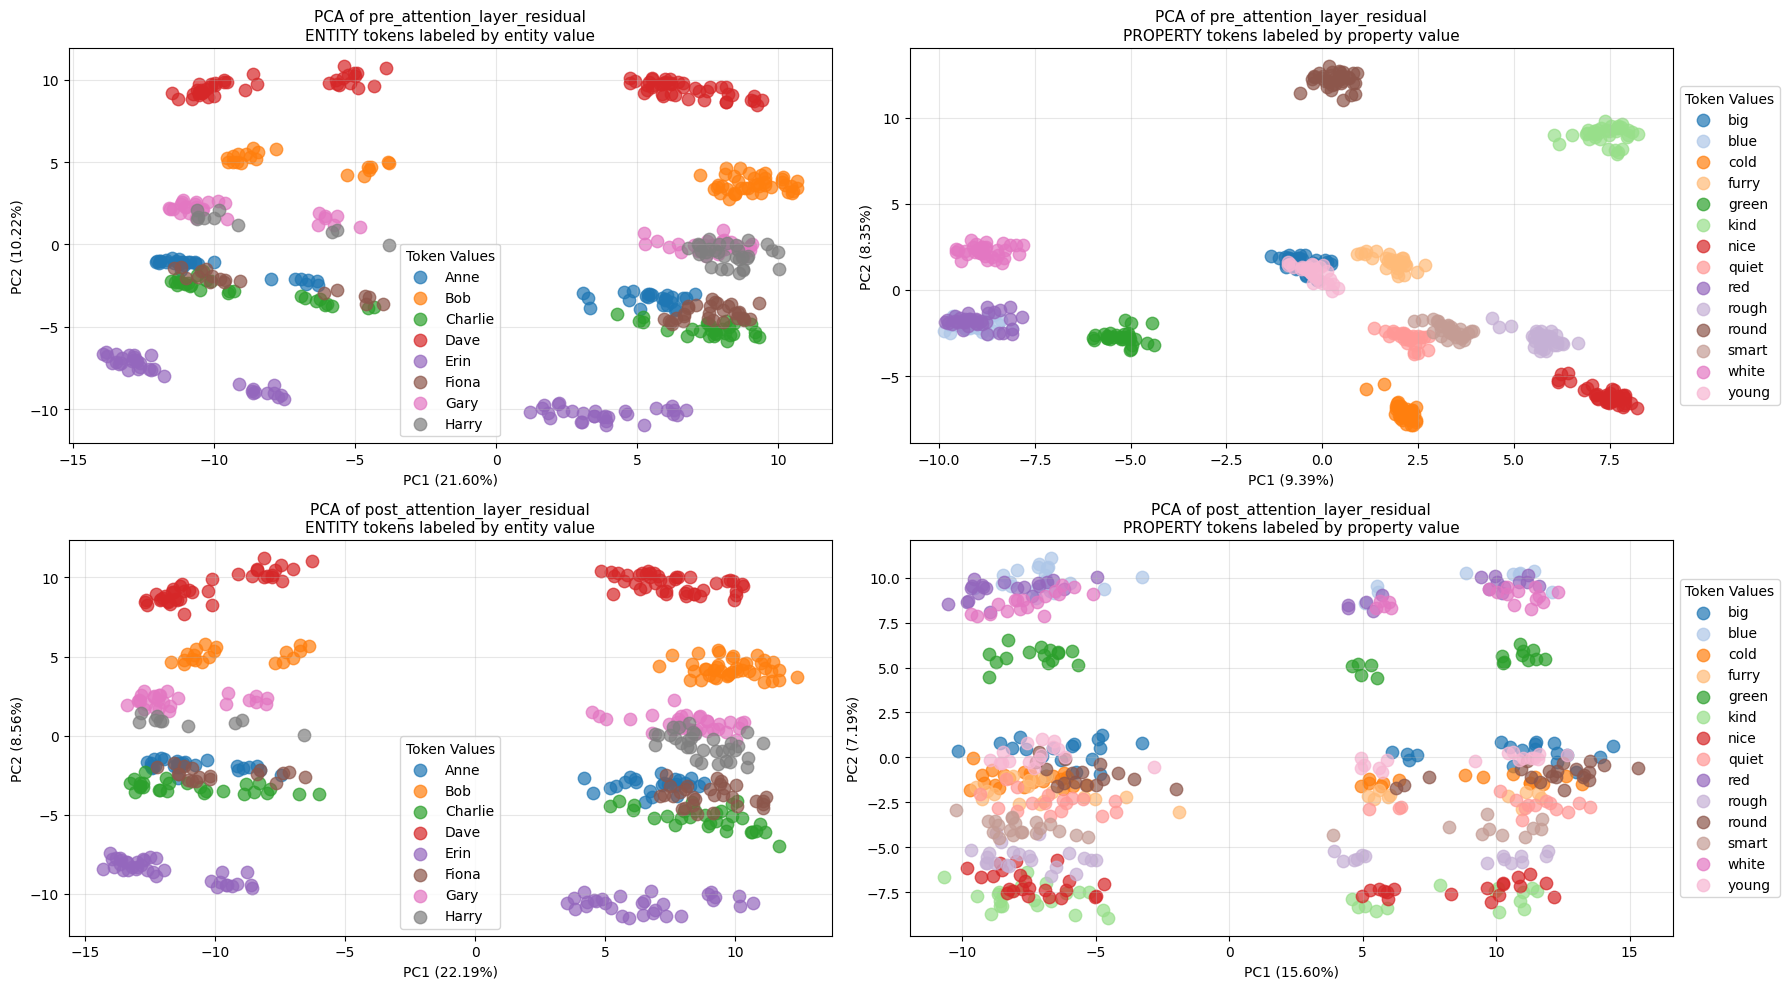

In [130]:
fig = visualize_pca_for_tokens(activations, object_tokens, property_tokens, hook_points[1:3], doc_to_batch, entity_property_map)
fig.savefig("combined_pca_plots_entity_labeled.png", bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
def advanced_pca_analysis_with_range(embeddings, labels, title_prefix, axes_row, start_pc=0, end_pc=20):
    """
    Perform PCA analysis for a specific range of principal components
    
    Parameters:
    - embeddings: Array of embeddings
    - labels: Labels for coloring (entity names)
    - title_prefix: Prefix for plot titles
    - axes_row: Row of matplotlib axes to plot on
    - start_pc: Start PC index (0-indexed, PC1 = 0)
    - end_pc: End PC index (inclusive)
    """
    # Apply PCA with sufficient components
    n_components = min(end_pc + 1, embeddings.shape[0], embeddings.shape[1])
    pca = PCA(n_components=n_components)
    projected = pca.fit_transform(embeddings)
    
    # Print cumulative explained variance
    exp_var = pca.explained_variance_ratio_.cumsum()
    print(f"Cumulative explained variance:")
    print(exp_var[:min(20, len(exp_var))])
    print(f"Number of PCs needed for 90% variance: {np.argmax(exp_var >= 0.9) + 1 if np.any(exp_var >= 0.9) else 'N/A'}")
    
    # Create a colormap for the unique labels
    unique_labels = sorted(list(set(labels)))
    num_labels = len(unique_labels)
    
    if num_labels <= 10:
        cmap = plt.cm.tab10
    elif num_labels <= 20:
        cmap = plt.cm.tab20
    else:
        colors = plt.cm.rainbow(np.linspace(0, 1, num_labels))
        cmap = ListedColormap(colors)
    
    # Create a dictionary mapping labels to colors
    label_to_color = {label: cmap(i % cmap.N) for i, label in enumerate(unique_labels)}
    
    # Generate PC pairs within the specified range
    pc_pairs = [(n, n+1) for n in range(start_pc, end_pc, 2) if n+1 < n_components]
    
    # Make sure we don't try to access more axes than available
    num_axes = len(axes_row)
    
    for i, (pc1, pc2) in enumerate(pc_pairs):
        # Skip if we're out of axes
        if i >= num_axes:
            print(f"Warning: Not enough axes to plot PC{pc1+1} vs PC{pc2+1}")
            continue
            
        ax = axes_row[i]
        
        # Plot each label group separately
        for label in unique_labels:
            mask = np.array(labels) == label
            ax.scatter(
                projected[mask, pc1], 
                projected[mask, pc2],
                c=[label_to_color[label]],
                label=label,
                alpha=0.7, 
                s=80
            )
        
        # Add legend for the first plot only (to avoid redundancy)
        if i == 0:
            if num_labels > 10:
                ax.legend(
                    title="Entities",
                    loc='center left',
                    bbox_to_anchor=(1, 0.5),
                    ncol=1
                )
            else:
                ax.legend(title="Entities", loc='best')
        
        # Set labels and title
        ax.set_xlabel(f'PC{pc1+1} ({pca.explained_variance_ratio_[pc1]:.2%})')
        ax.set_ylabel(f'PC{pc2+1} ({pca.explained_variance_ratio_[pc2]:.2%})')
        ax.set_title(f"PC{pc1+1} vs PC{pc2+1}", fontsize=10)
        ax.grid(alpha=0.3)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=11)
    
    return pca

In [112]:
def visualize_advanced_pca(activations, object_tokens, property_tokens, hook_points, doc_to_batch, entity_property_map, 
                          num_pcs=8, selected_hooks=None, use_entity_labels=True, apply_mean_centering=True, 
                          plot_object_tokens=False, pc_ranges=None):
    """
    Create advanced PCA visualizations showing multiple PC pairs for property tokens with entity labeling.
    
    Parameters:
    -----------
    activations : dict
        Dictionary containing activation tensors for different hook points
    object_tokens : DataFrame
        DataFrame containing the OBJECT tokens
    property_tokens : DataFrame
        DataFrame containing the PROPERTY tokens
    hook_points : list
        List of hook point names to analyze
    doc_to_batch : dict
        Mapping from document IDs to batch indices
    entity_property_map : dict
        Mapping from property token indices to their associated entities
    num_pcs : int, optional
        Default number of PCs to analyze (default: 8)
    selected_hooks : list, optional
        List of specific hook points to analyze (default: use all hook_points)
    use_entity_labels : bool, optional
        Whether to use entity names for PROPERTY tokens (default: True)
    apply_mean_centering : bool, optional
        Whether to apply mean-centering by token type for PROPERTY tokens (default: True)
    plot_object_tokens : bool, optional
        Whether to plot OBJECT tokens (default: False)
    pc_ranges : dict, optional
        Dictionary mapping hook points to PC ranges to plot. Format:
        {"hook_point_name": [start_pc, end_pc], ...}
        where start_pc is 0-indexed (PC1 = 0)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    # Filter hook points if specified
    if selected_hooks is not None:
        hooks_to_analyze = [h for h in hook_points if h in selected_hooks]
    else:
        hooks_to_analyze = hook_points
    
    # Default PC ranges if none provided
    if pc_ranges is None:
        pc_ranges = {hook: [0, num_pcs] for hook in hooks_to_analyze}
    else:
        # Ensure all hooks have ranges, use default for any missing
        for hook in hooks_to_analyze:
            if hook not in pc_ranges:
                pc_ranges[hook] = [0, num_pcs]
    
    # Figure out max columns needed for any row
    max_cols = max([((pc_ranges[hook][1] - pc_ranges[hook][0]) + 1) // 2 for hook in hooks_to_analyze])
    if plot_object_tokens:
        max_cols += 1
    
    # Create a figure with appropriate number of plots
    figsize = (max_cols * 4, 5 * len(hooks_to_analyze))
    fig, axes = plt.subplots(len(hooks_to_analyze), max_cols, figsize=figsize)
    
    # If we only have one hook point, adjust axes
    if len(hooks_to_analyze) == 1:
        axes = axes.reshape(1, -1)
    
    # Process each hook point
    for i, hook_point in enumerate(hooks_to_analyze):
        print(f"\nProcessing {hook_point}...")
        
        # Get the vertical position of this row's subplot for correct label placement
        # For a multi-row plot, use the middle of the row's height
        row_position = 1.0 - (i + 0.5) / len(hooks_to_analyze)
        
        # Add the hook point name as a row label on the left, with corrected vertical position
        fig.text(0.01, row_position, 
                hook_point, 
                va='center', ha='left', 
                rotation=90, fontsize=14)
        
        # Starting column for property plots depends on whether we're plotting object tokens
        prop_start_col = 1 if plot_object_tokens else 0
        
        # Get PC range for this hook point
        start_pc, end_pc = pc_ranges[hook_point]
        
        if plot_object_tokens:
            # Process OBJECT tokens (for reference, just showing PC1 vs PC2)
            object_embeddings, object_labels = extract_embeddings(
                object_tokens, activations, hook_point, doc_to_batch, entity_map=entity_property_map, use_entity_labels=False
            )
            print(f"  Found {len(object_embeddings)} OBJECT embeddings")
            
            if len(object_embeddings) > 0:
                # Plot PC1 vs PC2 for objects in first column
                ax = axes[i, 0]
                plot_pca_on_axis(
                    object_embeddings, 
                    object_labels,
                    "PC1 vs PC2",
                    ax
                )
            else:
                ax = axes[i, 0]
                ax.text(0.5, 0.5, "No OBJECT embeddings found", ha='center', va='center')
        
        # Process PROPERTY tokens with more comprehensive PCA analysis
        property_embeddings, property_labels = extract_embeddings(
            property_tokens, activations, hook_point, doc_to_batch, entity_map=entity_property_map, use_entity_labels=use_entity_labels
        )
        
        # Extract original property tokens for mean-centering
        original_property_labels = extract_embeddings(
            property_tokens, activations, hook_point, doc_to_batch, entity_map=None, use_entity_labels=False
        )[1]
        
        print(f"  Found {len(property_embeddings)} PROPERTY embeddings")
        
        if len(property_embeddings) > 0:
            if apply_mean_centering:
                print(f"  Applying mean-centering by token type")
                # Apply mean-centering by token type
                property_embeddings = mean_center_by_token_type(property_embeddings, original_property_labels)
            
            # Use advanced PCA analysis for property tokens with specified PC range
            axes_row = axes[i, prop_start_col:prop_start_col + ((end_pc - start_pc) + 1) // 2]
            advanced_pca_analysis_with_range(
                property_embeddings, 
                property_labels,
                "",  # Empty title prefix since we're using a shared title
                axes_row,
                start_pc=start_pc,
                end_pc=end_pc
            )
        else:
            for j in range(prop_start_col, max_cols):
                ax = axes[i, j]
                ax.text(0.5, 0.5, "No PROPERTY embeddings found", ha='center', va='center')
    
    # Adjust layout to accommodate row labels
    plt.subplots_adjust(left=0.05, right=0.98, wspace=0.3, hspace=0.3)
    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    
    # Create a shared title for the PROPERTY plots
    title_prefix = "Mean-centered " if apply_mean_centering else ""
    property_title = f"PCA of {title_prefix}PROPERTY tokens"
    
    # Add the shared title above the property plots
    fig.suptitle(property_title, fontsize=16, y=0.98)
    
    return fig


Processing post_attention_layer_residual...
  Found 477 PROPERTY embeddings
  Applying mean-centering by token type
Cumulative explained variance:
[0.3702879  0.49648702 0.5633451  0.6155827  0.6575035  0.69381523
 0.72573185 0.7546199  0.77731687 0.797381   0.81434965 0.8247337
 0.83474404 0.841733   0.8478585  0.85371405 0.85922647 0.864273  ]
Number of PCs needed for 90% variance: N/A


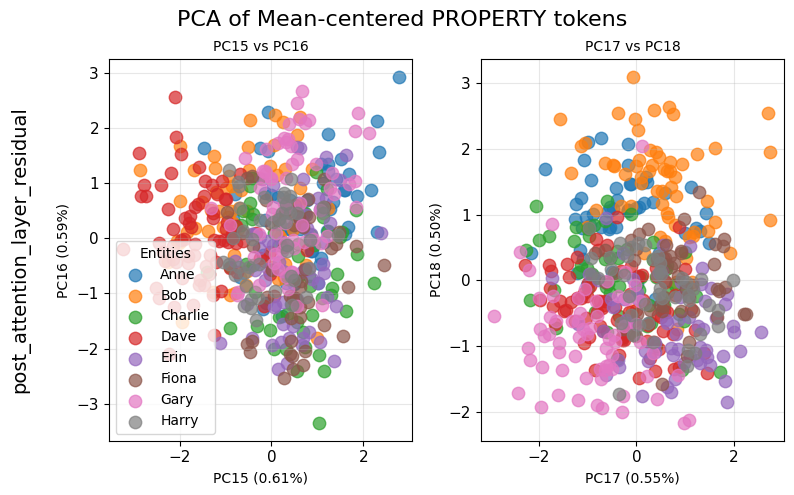

In [121]:
# Define specific PC ranges for each hook point
pc_ranges = {
    # "attention_layer_result": [2, 9],  # Plot PCs 1-12 (pairs: 1-2, 3-4, 5-6, 7-8, 9-10, 11-12)
    "post_attention_layer_residual": [14, 17]   # Plot PCs 11-22 (pairs: 11-12, 13-14, 15-16, 17-18, 19-20, 21-22)
}

fig = visualize_advanced_pca(
    activations, object_tokens, property_tokens, hook_points, doc_to_batch, entity_property_map,
    num_pcs=12, 
    selected_hooks=["post_attention_layer_residual"], 
    use_entity_labels=True, 
    apply_mean_centering=True, 
    plot_object_tokens=False,
    pc_ranges=pc_ranges
)

fig.savefig("advanced_pca_plots_custom_ranges.png", bbox_inches='tight', dpi=300)
plt.show()